### Tasks

- compute the steady background flow around an airfoil using the panel method you have implemented earlier
- compute the pathlines a massless particle realeased well upstream the airfoil at certain y0 will follow (these are the streamlines) until well downstream the airfoil. I am not totally sure what would be the best approach to do so, but has to be repeated for all relevant y0
- create an acoustic 1d mesh at the airfoil surface (maybe you could use just the panels if the dimensions make sense)
- define a sampling frequency and move a vortex along the pathline/streamline, compute the time-depended pressure from the vortex at all surface elements
- integrate over the surface elements to get the farfield sound pressure (Curle) at any generic location (field point x_p,y_p). This involves also to take into account the retarded time instants due to different distances between the panels and the field point. One option would be to interpolate, another option would be to take the FFT of p at each surface element and multiply by exp(-jkr). The latter is more easy to implement (frequency domain Curle's formulation). Finally you would have the farfield sound pressure due to 1 vortex (strength,size) that started at y0.
- repeat everything for different y0 and also for same y0, but different vortex size
- verify that the results are different and do not just scale with a factor
- repeat everything for same y0 and different strength
- verify that the results are the same, except for a certain factor

### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import psd
from steapy import *
import os
import numpy
from numpy import *
import math
from scipy import integrate, linalg
from matplotlib import pyplot
from pylab import *
import sympy
from sympy.abc import x, y

### Steady background flow around the airfoil
#### Solved using the steady vortex particle panel code 'steapy'.

In [2]:
# Parameters to define a NACA 4 digits airfoil
x=1
m=0.03
p=0.4
t=0.12 # maximum thickeness
c=1

coordinates_symmetrical(x, t, c)
#coordinate = coordinates_cambered(x, m, p, t, c)

'''
Comment or Incomment the file path for the specific type of airfoil

'''
# load geometry from data file
naca_filepath = os.path.abspath('NACA'+'_'+'00'+str(int(t*100))+'.txt') #SYMMETRICAL
#naca_filepath = os.path.abspath('NACA'+'_'+str(int(m*100))+str(int(p*10))+str(int(t*100))+'.txt') #CAMBERED
with open(naca_filepath, 'r') as infile:
    x, y = numpy.loadtxt(infile, dtype=float, unpack=True)

# discretize geoemetry into panels
panels = define_panels(x, y, N=40)

# define freestream conditions
freestream = Freestream(u_inf=1.0, alpha=0.0)

#solve the source contribution
A_source = source_contribution_normal(panels)

#solve the vortex contribution
B_vortex = vortex_contribution_normal(panels)

#build LHS and RHS
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)

# solve for singularity strengths
strengths = numpy.linalg.solve(A, b)

# store source strength on each panel
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]

[[5.00000000e-01 3.40155564e-04 4.30771154e-04 ... 5.01896142e-02
  1.58111619e-01 3.12646593e-01]
 [3.52546184e-05 5.00000000e-01 4.26442149e-04 ... 1.16130459e-01
  2.93882643e-01 1.64439946e-02]
 [6.59302673e-05 1.54014104e-04 5.00000000e-01 ... 2.66825827e-01
  3.37155191e-02 1.87039857e-03]
 ...
 [2.48486684e-03 3.37155191e-02 2.66825827e-01 ... 5.00000000e-01
  1.54014104e-04 1.04316880e-03]
 [2.02743243e-02 2.93882643e-01 1.16130459e-01 ... 4.26442149e-04
  5.00000000e-01 7.79234836e-03]
 [2.60773240e-01 2.20473585e-01 8.90788829e-02 ... 4.46929298e-02
  5.80760078e-02 5.00000000e-01]]
[[ 0.         -0.30854015 -0.13950998 ... -0.12723681 -0.20606565
   0.14291543]
 [ 0.08184394  0.         -0.23128594 ... -0.16833839  0.06088799
   0.08549521]
 [ 0.02698809  0.12697675  0.         ...  0.05085858  0.10952467
   0.03009426]
 ...
 [-0.02641539 -0.10952467 -0.05085858 ...  0.         -0.12697675
  -0.03031634]
 [-0.07255868 -0.06088799  0.16833839 ...  0.23128594  0.
  -0.09051304

### Plot the velocity field 
#### (just for visualisation and to prove the methodology is right)

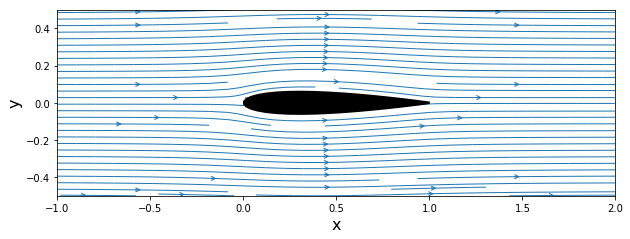

In [3]:
#define a mesh grid
nx, ny = 50, 50  # number of points in the x and y directions
x_start, x_end = -1.0, 2.0
y_start, y_end = -0.5, 0.5
X, Y = numpy.meshgrid(numpy.linspace(x_start, x_end, nx),
                      numpy.linspace(y_start, y_end, ny))

#compute the velocity field on the mesh grid
u, v = get_velocity_field(panels, freestream, X, Y)

#plot the velocity field
width = 10

pyplot.figure(figsize=(width, width))
#pyplot.figure(figsize=(20,20))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u, v,
                 density=1, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panels],
           [panel.yc for panel in panels],
           color='k', linestyle='solid', linewidth=2, zorder=3)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
# pyplot.ylim(1,-1)
#pyplot.title('Streamlines around a NACA 0012 airfoil (AoA = ${}^o$)'.format(alpha), fontsize=16);
# savefig('Velo_NACA'+'_'+str(int(m*100))+str(int(p*10))+str(int(t*100))+'.pdf')
show()

# Tracer particle coordinates

### NACA 4 digit airfoil generator

In [4]:
def naca_airfoil(code, num_points, zero_thick_te=False, uniform=False):
    """Return a NACA 4-digit series airfoil"""
    # extract parameters from 4-digit code
    code_str = "%04d" % int(code)
    if len(code_str) != 4:
        raise ValueError("NACA designation is more than 4 digits")
    max_camber = 0.01 * int(code_str[0])
    p = 0.1 * int(code_str[1])  # location of max camber
    thickness = 0.01 * int(code_str[2:])
    if uniform:
        x = np.linspace(0, 1, num_points)
    else:
        # closer spacing near leading edge
        theta = np.linspace(0, 0.5 * np.pi, num_points)
        x = 1 - np.cos(theta)

    # thickness
    coefs = [-0.1015, 0.2843, -0.3516, -0.1260, 0, 0.2969]
    if zero_thick_te:
        coefs[0] = -0.1036
    y_thick = 5 * thickness * (np.polyval(coefs[:5], x) +
                               coefs[5] * np.sqrt(x))

    # camber
    front = np.where(x <= p)
    back = np.where(x > p)
    y_camber = np.zeros_like(x)
    if p:
        y_camber[front] = max_camber * x[front] / p**2 * (2 * p - x[front])
        y_camber[back] = max_camber * ((1. - x[back])/(1. - p)**2 *
                                       (1 + x[back] - 2 * p))
    x = np.hstack([x[-1:0:-1], x])
    y = np.hstack([y_camber[-1:0:-1] + y_thick[-1:0:-1],
                   y_camber - y_thick])
    return (np.array([x, y]).T)

### Declaring a variable to store cooridnates of airfoil

In [5]:
q = naca_airfoil(0012, 101)

### Collacation point (obervations point on the airfoil where the vortex influence will be captured)

In [6]:
q_mid = (q[1:] + q[:-1])/2

### Defining the computational domain where the vortices are distributed

<img src="tracer.JPG" alt="Drawing" style="width: 700px;"/>

### Injecting vortex from x = -1.0, y = random (y_start, y_end)
origin at window center

In [15]:
import numpy as np
x_start = -1.0
y_start, y_end = -0.1, 0.1
ylim = y_start, y_end

#function to give a random number between y_lim
def random_y(ylim):
    yrange = np.diff(ylim)
    return yrange * np.random.rand(1)[0] + ylim[0]

random_y(ylim)
# print (random_y)


pts = [] # empty list
pts = list(pts)
pts=((x_start, random_y(ylim)[0]))
# pts=((x_start, 0))
pts = (-1.0, -0.1) #fixed position for testing 
# print pts
pts = np.asarray(pts)
x, y = np.asarray(pts).transpose()
print (x,y)

(-1.0, -0.1)


<function matplotlib.pyplot.show>

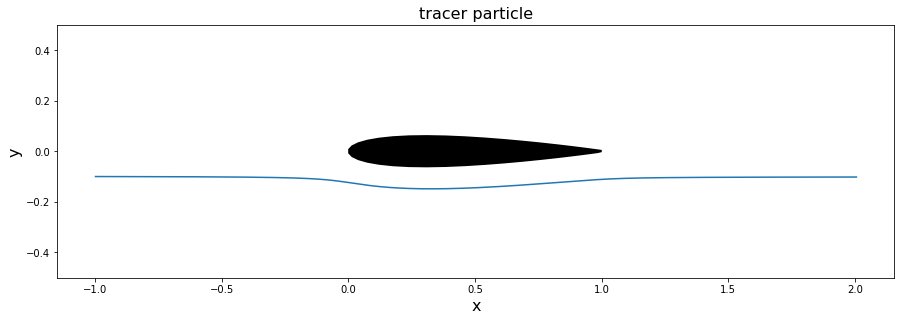

In [16]:
t0 = x_start  #start time for observation of convection
t1 = x_start + 3   #end time
dt = 0.001 # time step
t = np.arange(t0,t1,dt) # number of time-steps
a = np.zeros((1,len(t)))
b = np.zeros((1,len(t)))

for i in range(0,len(t)):
    vel = (np.asarray(get_velocity_field(panels, freestream, x, y))).T
#    print (vel)
    pts = pts + (vel*dt)
    x, y = np.asarray(pts).transpose()
#     print (pts)
    a[0,i] = x
    b[0,i] = y
    
vortX = np.vstack((a,b))
#print vortX

plt.figure(figsize=(15, 5))
plt.plot(vortX[0],vortX[1],label='streamline')
pyplot.fill([panel.xc for panel in panels],
           [panel.yc for panel in panels],
           color='k', linestyle='solid', linewidth=2, zorder=3)
plt.title('tracer particle',fontsize=16)
plt.xlabel('x',fontsize=16)
plt.ylabel('y',fontsize=16)
pyplot.axis('scaled', adjustable='box')
#pyplot.xlim(-1,2)
pyplot.ylim(-0.5,0.5)
#plt.savefig('tracer.pdf')
plt.show

### Calculating distance between the vortex and each panel on airfoil surface

In [17]:
obsx = q_mid[:,0]
# obsx = (obsx - i )
obsy = q_mid[:,1]
obsX = np.vstack((obsx,obsy))
# print obsX
dist = obsX[:,:,np.newaxis]-vortX[:,np.newaxis,:] # dim 2 x timesteps x N
r = np.sqrt((dist*dist).sum(0)) # dim timesteps x N
print r

[[1.99376381 1.99277382 1.99178384 ... 1.01782322 1.01881219 1.01980117]
 [1.97817282 1.97718289 1.97619299 ... 1.03363046 1.03461941 1.03560838]
 [1.96258924 1.96159939 1.96060955 ... 1.04942841 1.05041734 1.05140629]
 ...
 [1.96202585 1.96103571 1.96004558 ... 1.04835383 1.04934379 1.05033376]
 [1.97779254 1.97680242 1.97581232 ... 1.03288828 1.03387795 1.03486763]
 [1.99356724 1.99257715 1.99158707 ... 1.01743059 1.01841995 1.01940932]]


### Vortex strength and size

In [18]:
gammas = 1. #vortex strength RMS (normal distribution)
rscale = 0.5 #vortex size scale (rayleigh distribution parameter)
# gamma = np.random.normal(scale=gammas)
rho = np.random.rayleigh(scale=rscale)
print gamma, rho

1.035260581 1.18066553678


### Velocity calculation

In [19]:
gamma = 1.035260581
# gamma = 10
rho = 0.9
utheta = 16 * gamma * (rho**(-3)) * np.exp(-8*(rho**(-4)) * r**2) * (3-(16 * (rho**(-4)) * r**2)) * r   # Mexican-hat shape
# utheta = format(utheta)
# print utheta
savetxt('utheta.txt',np.column_stack(utheta), fmt='%0.5f', delimiter=',')
uind = utheta * dist[::-1] # dim 2 x timesteps x N
# print uind
uind[0] *= -1 # change sign for ux (to get correct rotation)
ux = uind[0].T
# print uind
# print uind.T
savetxt('utheta_mag_i_j.txt',np.column_stack((utheta,uind[0],uind[1])), fmt='%0.5f', delimiter=',')
# utot = uind.sum(2) # dim 2 x timesteps
# print utot

### Pressure calculation using Bernoulli's equation

In [20]:
v0 = 1 # empty array to store cl value after each iteration
q_newx = q[:,0]
q_newy = q[:,1]
q = np.array([q_newx, q_newy]).T
dq = np.diff(q, axis=0)
numpanels = dq.shape[0]
lengths = np.linalg.norm(dq, axis=1) 
# print lengths
normals = np.transpose(np.array([dq[:,1], -dq[:,0]]) / lengths)
tangents = -np.transpose(np.array([dq[:,0], dq[:,1]]) / lengths)
# print tangents
utot_tangent = uind.T * tangents
# utot_tangent = uind.T
# print utot_tangent
# print utot_tangent[:,:,0]
utot_tangent_magnitude = pow((pow(utot_tangent[:,:,0],2) + pow(utot_tangent[:,:,1],2)), 0.5)
# print utot_tangent_magnitude
p_ref =0
# p = p_ref + (0.5 * 1.225 * (1**2 - utot_tangent_magnitude**2))
p = p_ref + (0.5 * 1.225 * (1**2 - ux**2))
dp_ = np.diff(p, axis=0)
dp = dp_ * lengths
#dp = dp*lengths
# print len(p)
F = dp_ * lengths
# print F
G = F.sum(axis=1) # dim 2 x timesteps
# print len(G)
cp = (1 - ((utot_tangent_magnitude**2)/v0**2))
cp = cp * normals[:,1]
# print cp

<function matplotlib.pyplot.show>

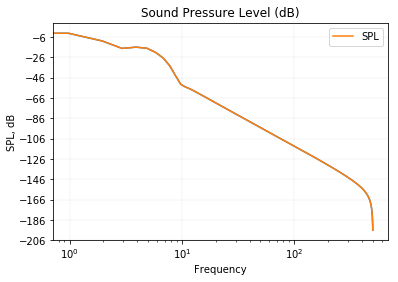

In [21]:
obs_x = 0
# obsx = (obsx - i )
obs_y = 1
obs_X = np.vstack((obs_x,obs_y))
# print obsX
vort_X = np.vstack((q_mid[:,0],q_mid[:,1]))
#print vort_X
dist_ = obs_X[:,:,np.newaxis]-vort_X[:,np.newaxis,:] # dim 2 x timesteps x N
r_ = np.sqrt((dist_*dist_).sum(0)) # dim timesteps x N
#print r_

tau = dt - (r_/340)

p_acoustic = (((obs_X*(normals.T)).sum(0))/(4*np.pi*340)) * ((dp/(tau*(r_**2)))[np.newaxis])
#var_1 = (dp/(tau*(r_**2)))[np.newaxis]
p_acoustic_1 = p_acoustic[0,:,:].sum(axis=1)

H_NC = ((np.abs(p_acoustic_1))/(2.e-5))**2
# print H
(val_NC, freq_NC) = psd(H_NC,NFFT=1024,Fs=1/dt,detrend='mean')
SPL = 10*np.log10(val_NC)
#savetxt('SPL.csv', np.column_stack((freq,SPL)), fmt='%0.5f', delimiter=',')
# print SPL
#plt.savefig('SPL.pdf')
#print freq
plt.semilogx(freq_NC,10*np.log10(val_NC),linestyle='-',alpha=1.0,label='SPL')
plt.title('Sound Pressure Level (dB)')
plt.xlabel('Frequency')
plt.ylabel('SPL, dB',labelpad=1.5)
plt.grid(color='0.5',linestyle=':',linewidth=0.2)
plt.legend()
# plt.savefig('SPL_chack.pdf')
plt.show

In [55]:
print G
print len(G)

[0. 0. 0. ... 0. 0. 0.]
2999


### Curle's analogy to obtain p' at a distance of 1 unit at theta=90 deg

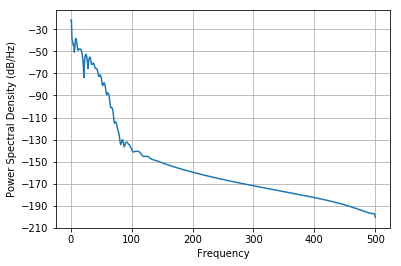

In [56]:
def Curles_loadingNoise(y_int,c_sound,r_dist,L,dt,Velo):
#     p_acoustic = (((y_int*L)/(4*np.pi*dt*c_sound*(r_dist**2)))*(0.5*1.225*pow(Velo,2)))
    p_acoustic = (((y_int*L)/(4*np.pi*dt*c_sound*(r_dist**2))))
    return p_acoustic

noise = Curles_loadingNoise(1,343,1,G,dt,v0)
# print noise
H = ((noise)/(2.e-5))**2
# print H
(val, freq) = psd(H,NFFT=1024,Fs=1/dt,detrend='mean')
SPL = 10*np.log10(val)
savetxt('SPL.csv', np.column_stack((freq,SPL)), fmt='%0.5f', delimiter=',')
# print SPL
plt.savefig('SPL.pdf')
# print freq

<function matplotlib.pyplot.show>

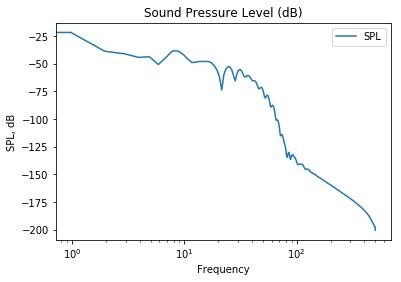

In [57]:
plt.semilogx(freq,10*np.log10(val),label='SPL')
plt.title('Sound Pressure Level (dB)')
plt.xlabel('Frequency')
plt.ylabel('SPL, dB')
plt.legend()
plt.savefig('SPL1.pdf')
plt.show

<function matplotlib.pyplot.show>

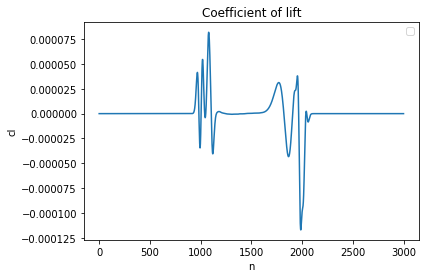

In [58]:
plt.plot(-G/(0.5*1.225*v0**2*lengths.sum()))
plt.title('Coefficient of lift')
plt.xlabel('n')
plt.ylabel('cl')
plt.legend()
# plt.savefig('SPL1.pdf')
plt.show

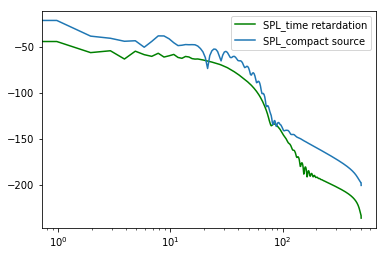

In [59]:
plt.figure(2)
#plt.subplot(1,2,1)
plt.semilogx(freq_NC,10*np.log10(val_NC),label='SPL_time retardation',color='green') # compact source
plt.semilogx(freq,10*np.log10(val),label='SPL_compact source') # non-compact source
# plt.semilogx(freq_L,10*np.log10(val_L),label='SPL_t-f-t')
plt.legend()